In [18]:
import csv
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import epsilon

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import cv2

DATA_DIR = "images"

# 0.35, 0.5, 0.75, 1.0, 1.3, 1.4
# ALPHA = 0.75

# 96, 128, 160, 192, 224
IMAGE_SIZE = 224


EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20

data = pd.read_csv('training.csv')
train, test = train_test_split(data, test_size=0.1, random_state=123)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train.to_csv('train.csv', index=False)
test.to_csv('validation.csv', index=False)

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

In [19]:
class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.mask = np.zeros((sum(1 for line in file)-1, GRID_SIZE, GRID_SIZE))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")

            for index, row in enumerate(reader):
                if index == 0:
                    continue
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)
                
                path, x0, x1, y0, y1 = row
                path = os.path.join(DATA_DIR,path)

                img = Image.open(path)
                image_width, image_height = img.size

                cell_start_x = np.rint(((GRID_SIZE - 1) / image_width) * x0).astype(int)
                cell_stop_x = np.rint(((GRID_SIZE - 1) / image_width) * x1).astype(int)

                cell_start_y = np.rint(((GRID_SIZE - 1) / image_height) * y0).astype(int)
                cell_stop_y = np.rint(((GRID_SIZE - 1) / image_height) * y1).astype(int)

                self.mask[index-1, cell_start_y : cell_stop_y, cell_start_x : cell_stop_x] = 1

                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.mask) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_masks = self.mask[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        if len(batch_paths) != len(batch_masks):
            print(":/ :/")

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, batch_masks[:,:,:,np.newaxis]


In [20]:

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        numerator = 0
        denominator = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)

            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0

            numerator += 2 * np.sum(gt * pred)
            denominator += np.sum(gt + pred)

        dice = np.round(numerator / denominator, 4)
        logs["val_dice"] = dice

        print(" - val_dice: {}".format(dice))

In [21]:
def create_model(trainable=True):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights=None)

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("block_5_add").output
    block2 = model.get_layer("block_12_add").output
    block3 = model.get_layer("block_15_add").output

    blocks = [block2, block1]

    x = block3
    for block in blocks:
        x = UpSampling2D()(x)

        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Concatenate()([x, block])

        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    return Model(inputs=model.input, outputs=x)

In [22]:

def loss(y_true, y_pred):
    def dice_coefficient(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
        denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

        return numerator / (denominator + epsilon())

    
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + epsilon())

In [23]:
model = create_model(trainable=TRAINABLE)
model.summary()

if TRAINABLE:
    model.load_weights(WEIGHTS)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 24) 648         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 24) 96          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [24]:
train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[])

checkpoint = ModelCheckpoint("mobilenetV2-{val_dice:.2f}.h5", monitor="val_dice", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="val_dice", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_dice", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="max")

NameError: name 'GRID_SIZE' is not defined

In [98]:
model.fit_generator(generator=train_datagen,
                        epochs=EPOCHS,
                        callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                        workers=THREADS,
                        use_multiprocessing=MULTI_PROCESSING,
                        shuffle=True,
verbose=1)

Epoch 1/200
393/394 [============================>.] - ETA: 0s - loss: 332.5531 - val_dice: 0.8899

Epoch 00001: val_dice improved from -inf to 0.88990, saving model to model-0.89.h5
394/394 [==============================] - 237s 602ms/step - loss: 332.5845
Epoch 2/200
392/394 [============================>.] - ETA: 0s - loss: 330.7323 - val_dice: 0.9036000000000001

Epoch 00002: val_dice improved from 0.88990 to 0.90360, saving model to model-0.90.h5
394/394 [==============================] - 86s 217ms/step - loss: 330.6567
Epoch 3/200
393/394 [============================>.] - ETA: 0s - loss: 330.0901 - val_dice: 0.9242

Epoch 00003: val_dice improved from 0.90360 to 0.92420, saving model to model-0.92.h5
394/394 [==============================] - 86s 219ms/step - loss: 330.0227
Epoch 4/200
392/394 [============================>.] - ETA: 0s - loss: 329.4657 - val_dice: 0.9299000000000001

Epoch 00004: val_dice improved from 0.92420 to 0.92990, saving model to model-0.93.h5
394/394 [

Process ForkPoolWorker-320:
Process ForkPoolWorker-332:
Process ForkPoolWorker-330:
Process ForkPoolWorker-325:
Process ForkPoolWorker-335:
Process ForkPoolWorker-327:
Process ForkPoolWorker-321:
Process ForkPoolWorker-322:
Process ForkPoolWorker-338:
Traceback (most recent call last):
Process ForkPoolWorker-328:
Process ForkPoolWorker-337:
Process ForkPoolWorker-336:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_b

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 438, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-92-3d1d52d6ef12>", line 46, in __getitem__
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/applications/mobilenet_v2.py", line 44, in preprocess_input
    return mobilenet_v2.preprocess_input(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  

KeyboardInterrupt: 

KeyboardInterrupt
  File "<ipython-input-92-3d1d52d6ef12>", line 46, in __getitem__
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  File "/usr/local/lib/python3.5/dist-packages/PIL/Image.py", line 1782, in resize
    self.load()
KeyboardInterrupt
  File "/usr/local/lib/python3.5/dist-packages/PIL/Image.py", line 1782, in resize
    self.load()
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 50, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/local/lib/python3.5/dist-packages/PIL/ImageFile.py", line 239, in load
    n, err_code = decoder.decode(b)
  File "/usr/local/lib/python3.5/dist-packages/PIL/ImageFile.py", line 239, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


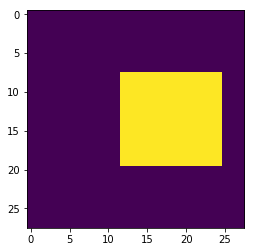

In [100]:
plt.imshow(train_datagen.mask[1])

In [117]:
IMAGES = "images/*png"
THRESHOLD = 0.5
EPSILON = 0.02

In [118]:
for filename in glob.glob(IMAGES)[8000:8010]:
    unscaled = cv2.imread(filename)
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = np.squeeze(model.predict(feat_scaled[np.newaxis,:]))
    boxes = []
    for j in range(region.shape[1]):
        for i in range(region.shape[0]):
            if region[i][j] > 0.5:
                x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
                y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
                x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
                y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
                if not boxes or boxes[-1][2] < x:
                    boxes.append([x, y, x2, y2])
                else:
                    boxes[-1][0] = min(x, boxes[-1][0])
                    boxes[-1][1] = min(y, boxes[-1][1])
                    boxes[-1][2] = max(x2, boxes[-1][2])
                    boxes[-1][3] = max(y2, boxes[-1][3])

    for box in boxes:
        x0,y0,x1,y1 = box
        cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 255, 0), 1)

    plt.imshow(unscaled)
    plt.show()

IndentationError: expected an indented block (<ipython-input-118-5473a011c58c>, line 11)

In [110]:
unscaled

NameError: name 'unscaled' is not defined